In [1]:
!pip install --upgrade datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 

In [2]:
from datasets import load_dataset
dataset = load_dataset("cifar10", split="train")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [3]:
import numpy as np
import tensorflow as tf
from datasets import load_dataset

# Ensure the dataset is loaded
dataset = load_dataset("cifar10", split="train")

# Extract and resize first 1000 images to 64×64
# Access the 'img' column directly from the dataset slice
images = dataset[:1000]['img']

# Convert PIL to NumPy and resize
# Note: When accessing a column like 'img', the result is a list of PIL images.
# We iterate over this list to convert to NumPy and resize.
x_resized = np.array([tf.image.resize(np.array(img), (64, 64)).numpy() for img in images])
x_resized = x_resized.astype('float32') / 255.0

print("Shape:", x_resized.shape)  # (1000, 64, 64, 3)

Shape: (1000, 64, 64, 3)


In [4]:
from tensorflow.keras import layers, models, losses, optimizers

def build_autoencoder(input_shape=(64, 64, 3), dropout_rate=0.3):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Dropout(dropout_rate)(x)


    encoded = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(inputs, decoded)
    encoder = models.Model(inputs, encoded)

    return autoencoder, encoder


# Build and compile
autoencoder, encoder = build_autoencoder()
autoencoder.compile(optimizer=optimizers.Adam(1e-3), loss=losses.MeanSquaredError())


In [5]:
history = autoencoder.fit(
    x_resized, x_resized,
    epochs=30,
    batch_size=64,
    validation_split=0.1
)


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 0.0606 - val_loss: 0.0474
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0465 - val_loss: 0.0440
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.0271 - val_loss: 0.0655
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.0190 - val_loss: 0.0753
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.0165 - val_loss: 0.0814
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0149 - val_loss: 0.0734
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.0136 - val_loss: 0.0785
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0116 - val_loss: 0.0755
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.0111 - val_loss: 0.0617
Epoch 10/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.0097 - val_loss: 0.0587
Epoch 11/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.0092 - val_loss: 0.0622
Epoch 12/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 0.0091 - val_lo

In [6]:
# Embedding extraction
embeddings = encoder.predict(x_resized).reshape((x_resized.shape[0], -1))

# Clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Evaluation
from sklearn.metrics import silhouette_score, davies_bouldin_score
sil_score = silhouette_score(embeddings, cluster_labels)
db_score = davies_bouldin_score(embeddings, cluster_labels)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_score:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step
Silhouette Score: 0.0294
Davies-Bouldin Index: 3.2697


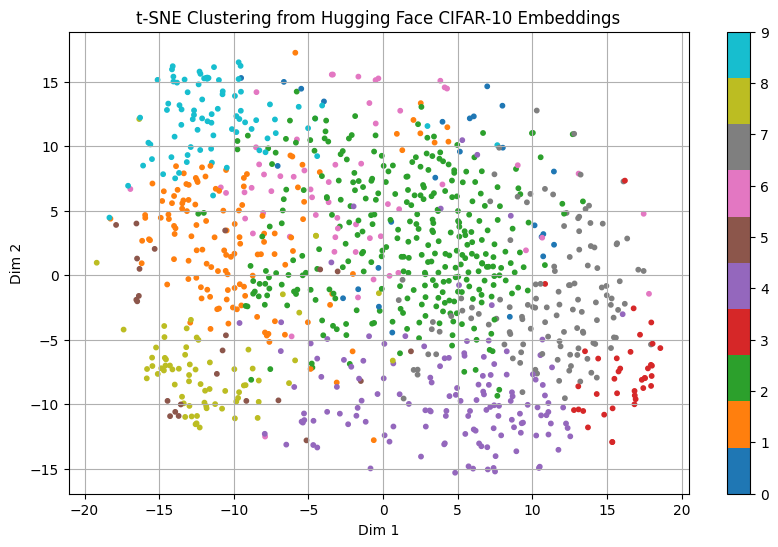

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.colorbar()
plt.title("t-SNE Clustering from Hugging Face CIFAR-10 Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()


In [8]:
from sklearn.cluster import DBSCAN

# Use DBSCAN instead of KMeans
dbscan = DBSCAN(eps=5, min_samples=5)
cluster_labels = dbscan.fit_predict(embeddings)

# Some points may be labeled -1 (noise)
print("Number of clusters (excluding noise):", len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0))


Number of clusters (excluding noise): 1


In [14]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Only evaluate if DBSCAN found valid clusters
if len(set(cluster_labels)) > 1:
    print("Silhouette Score:", silhouette_score(embeddings, cluster_labels))
    print("Davies-Bouldin Index:", davies_bouldin_score(embeddings, cluster_labels))
else:
    print("DBSCAN found fewer than 2 clusters.")


DBSCAN found fewer than 2 clusters.


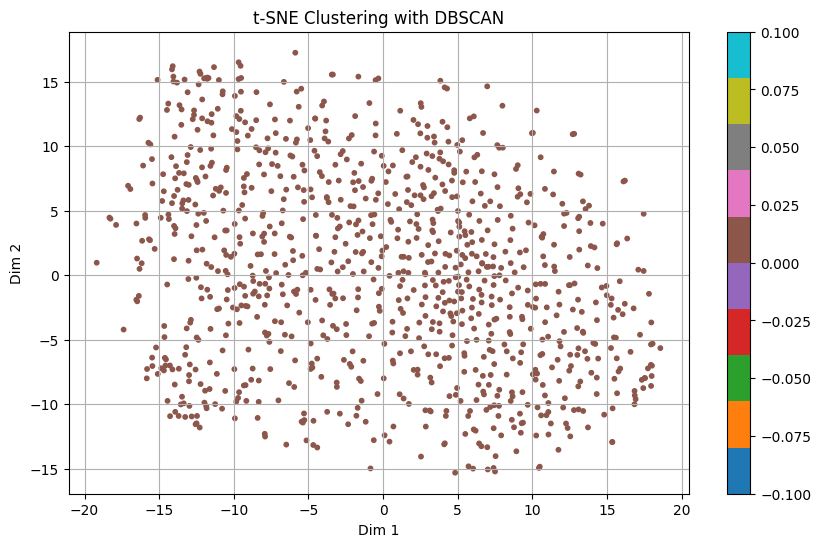

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.colorbar()
plt.title("t-SNE Clustering with DBSCAN")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()


In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Resize images to 224x224 and preprocess for ResNet50
x_resnet = np.array([tf.image.resize(np.array(img), (224, 224)).numpy() for img in images])
x_resnet = tf.keras.applications.resnet50.preprocess_input(x_resnet.astype('float32'))

# Step 2: Load pretrained ResNet50 without top layer
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
resnet_model = Model(inputs=base_model.input, outputs=x)

# Step 3: Extract embeddings batch-wise
batch_size = 32
resnet_ds = tf.data.Dataset.from_tensor_slices(x_resnet).batch(batch_size)

resnet_embeddings = []
for batch in resnet_ds:
    features = resnet_model(batch, training=False)
    resnet_embeddings.append(features.numpy())

resnet_embeddings = np.concatenate(resnet_embeddings, axis=0)
print("ResNet Embeddings shape:", resnet_embeddings.shape)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet Embeddings shape: (1000, 2048)


In [12]:
# Step 4: Clustering with KMeans
kmeans_resnet = KMeans(n_clusters=10, random_state=42)
resnet_labels = kmeans_resnet.fit_predict(resnet_embeddings)

# Step 5: Evaluation
sil_score_resnet = silhouette_score(resnet_embeddings, resnet_labels)
db_score_resnet = davies_bouldin_score(resnet_embeddings, resnet_labels)

print(f"[ResNet] Silhouette Score: {sil_score_resnet:.4f}")
print(f"[ResNet] Davies-Bouldin Index: {db_score_resnet:.4f}")


[ResNet] Silhouette Score: 0.0404
[ResNet] Davies-Bouldin Index: 3.9020


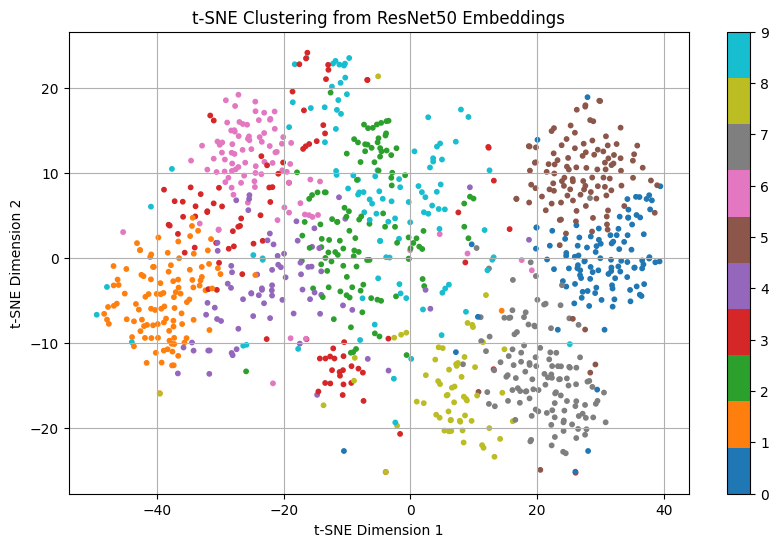

In [13]:
resnet_tsne = TSNE(n_components=2, random_state=42).fit_transform(resnet_embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(resnet_tsne[:, 0], resnet_tsne[:, 1], c=resnet_labels, cmap='tab10', s=10)
plt.colorbar()
plt.title("t-SNE Clustering from ResNet50 Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()
